필요 라이브러리 import

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np


데이터 불러오기/체크

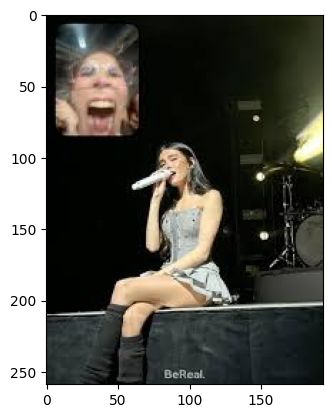

In [2]:
train = pd.read_csv("data/train.csv")

sample_img = Image.open(train.iloc[1531]["path"])
plt.imshow(sample_img)

이미지 파일 사이즈 분포 시각화

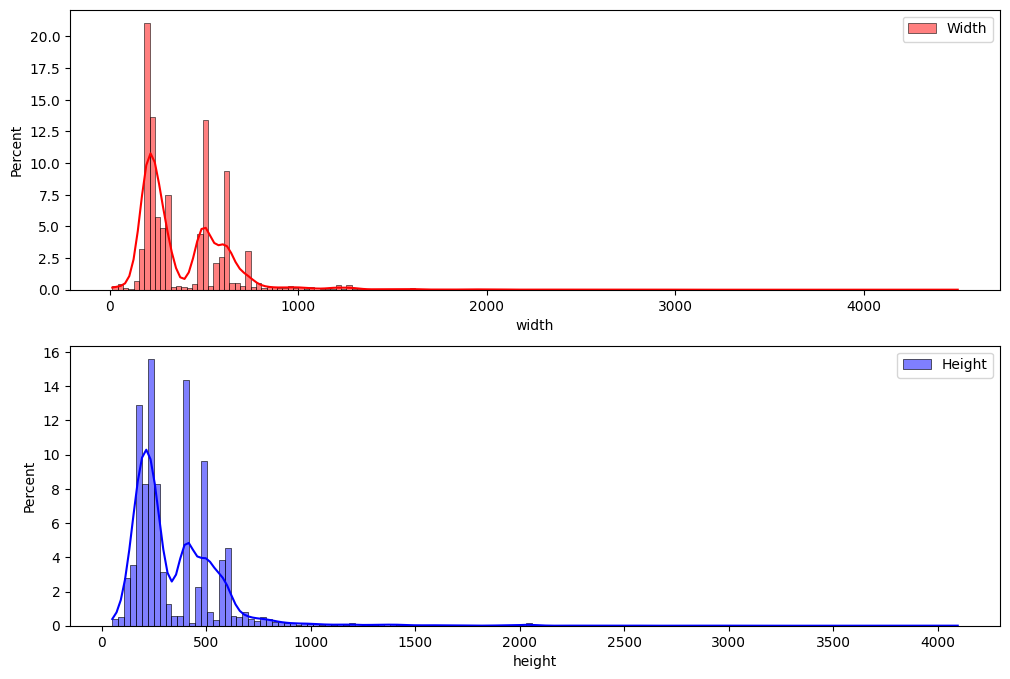

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.set_palette('tab10')
sns.histplot(train, x='width', kde=True, stat='percent', label='Width', ax=ax[0], color='r')
ax[0].legend()
sns.histplot(train, x='height', kde=True, stat='percent', label='Height', ax=ax[1], color='b')
ax[1].legend()

In [4]:
print(
    f"[너비] 평균: {train['width'].mean()}\n"
    f"[너비] 중간값(median): {train['width'].median()}\n"
    f"[너비] 표준편차: {train['width'].std(ddof=0)}"
)
print("=" * 50)
print(
    f"[높이] 평균: {train['height'].mean()}\n"
    f"[높이] 중간값(median): {train['height'].median()}\n"
    f"[높이] 표준편차: {train['height'].std(ddof=0)}"
)

[너비] 평균: 396.0065581184984
[너비] 중간값(median): 293.5
[너비] 표준편차: 266.9019493513948
[높이] 평균: 355.03279059249206
[높이] 중간값(median): 267.0
[높이] 표준편차: 240.46444688100263


CNN에 넣을 이미지 데이터는 모두 같은 사이즈를 가져야 함, 너무 크면 안됨 -> 너비, 높이 평균값을 가져온 후 둘 모두 256 이하가 될때까지 2를 나눈 값을 사용하고자 함

In [5]:
img_height, img_width = train['width'].mean(), train['height'].mean()
while 1:
    if img_height > 256 or img_width > 256:
        img_width = int(img_width // 2)
        img_height = int(img_height // 2)
    else:
        break

print(img_height, img_width)

# img_height, img_width = 224, 224

198 177


dataset에서 필요한 정보인 path와 class만 가져옴, 다중 분류이기 때문에 클래스에 레이블 인코딩 적용

In [21]:
import pickle
path = train['path']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train['class'])

labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_encoder.classes_))
print(train['class'])
print(len(labels[0]))
with open('models/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)
classes = len(labels[0])

0       addict
1       addict
2       addict
3       addict
4       addict
         ...  
8839     wojak
8840     wojak
8841     wojak
8842     wojak
8843     wojak
Name: class, Length: 8844, dtype: object
30


차후 사용할 datasetV2 자료형은 train_test_split을 지원하지 않음 -> 미리 나눈 후 datasetV2로 변환

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(path, labels, test_size=0.2, random_state=123)

더 효율적인 학습을 위해 path, class를 datasetV2 자료형으로 변형

In [8]:
def image_preprocessing(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3) #이미지 디코딩, 컬러(RGB)이미지기에 channels는 3으로 지정
    image = tf.image.resize(image, [img_height, img_width])  # 이미지 크기 조정
    image = image / 255.0  # RGB값은 0~255의 값을 가짐 -> 255로 나누어 0~1의 값으로 정규화

    return image, label

def create_dataset(paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels)) #path, labels를 datasetV2로 만듦
    dataset = dataset.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE) #전처리
    dataset = dataset.shuffle(buffer_size=len(paths)) #기존 데이터셋은 레이블별로 모여 있음 -> 스까스까
    dataset = dataset.batch(batch_size) #한 번에 몇개 씩 입력될지 지정
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) #데이터 셋을 미리 로드해 병목현상 방지
    return dataset

batch_size = 32
train_1 = create_dataset(X_train, y_train, batch_size)
test = create_dataset(X_test, y_test, batch_size)
print(len(train_1))

222


모델 정의

In [9]:
model = tf.keras.Sequential([
    #Conv2D layer 설정 - 필터 32개, 커널 사이즈 3*3, 패딩 설정, 활성화 함수 relu, 첫 layer - 입력 이미지 크기 정의
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding='same',
        activation='relu',
        input_shape=(img_height, img_width, 3)
    ),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Flatten(), #1차원 데이터로 변경
    tf.keras.layers.Dense(classes, activation='softmax') #class의 종류 수 만큼 분류
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 177, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 198, 177, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1121472)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │    33,644,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,645,086 (128.35 MB)

 Trainable params: 33,645,086 (128.35 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
num_epochs = 30
history = model.fit(train_1, epochs=num_epochs, validation_data=test)

Epoch 1/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 52s 216ms/step - accuracy: 0.5361 - loss: 10.0130 - val_accuracy: 0.8185 - val_loss: 0.8584
Epoch 2/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 51s 214ms/step - accuracy: 0.9214 - loss: 0.3303 - val_accuracy: 0.8242 - val_loss: 0.8260
Epoch 3/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - accuracy: 0.9799 - loss: 0.0981 - val_accuracy: 0.8406 - val_loss: 0.8147
Epoch 4/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 52s 216ms/step - accuracy: 0.9947 - loss: 0.0326 - val_accuracy: 0.8525 - val_loss: 0.8128
Epoch 5/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 53s 220ms/step - accuracy: 0.9916 - loss: 0.0474 - val_accuracy: 0.8406 - val_loss: 0.9249
Epoch 6/30
 12/222 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.9966 - loss: 0.0278

KeyboardInterrupt: 

학습 결과 시각화

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

트레이닝 데이터 셋에선 급격한 상승을 보이지만 테스트 데이터셋은 80퍼 미만의 정확도를 보이는 것으로 보임 -> 과적합됨 -> 해결 방법은?

1: 데이터 증강 시도

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(f'{path[0]}')  # PIL 이미지
x = img_to_array(img)  # (3, 150, 150) 크기의 NumPy 배열
x = x.reshape((1,) + x.shape)  # (1, 3, 150, 150) 크기의 NumPy 배열

# 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
# 지정된 `preview/` 폴더에 저장합니다.
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='augmentated', save_prefix='aug', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # 이미지 20장을 생성하고 마칩니다

In [11]:
import random

def image_preprocessing(path, label):
    image = tf.io.read_file(path) #이미지 파일 로드
    image = tf.image.decode_jpeg(image, channels=3) #이미지 디코딩, 컬러(RGB)이미지기에 channels는 3으로 지정
    image = tf.image.resize(image, [img_height, img_width])  # 이미지 크기 조정
    image = image / 255.0  # RGB값은 0~255의 값을 가짐 -> 255로 나누어 0~1의 값으로 정규화

    return image, label

def data_augmentation(image, label):
    image_modi = image
    i = random.randrange(1,10)
    if i == 7:
        image_modi = tf.image.random_flip_left_right(image_modi) #좌우 반전 - 좌우 반전되는 경우가 소수 -> 낮은 확률로 실행 
        #image_modi = tf.image.random_flip_up_down(image_modi) - 밈의 경우 상하 반전을 하는 경우는 거의 없음 -> 주석처리
    image_modi = tf.image.random_brightness(image_modi, max_delta=0.1) #밝기 조절
    image_modi = tf.image.random_contrast(image_modi, lower=0.9, upper=1.1) #대비 조절
    image_modi = tf.image.random_saturation(image_modi, lower=0.9, upper=1.1) #채도 조절
    image_modi = tf.image.random_hue(image_modi, max_delta=0.1) #색조 조절

    noise = tf.random.normal(shape=tf.shape(image_modi), mean=0.0, stddev=1.0, dtype=tf.float32)
    image_modi = tf.add(image_modi, noise) #노이즈 추가
    image_modi = tf.image.random_jpeg_quality(image_modi, min_jpeg_quality=70, max_jpeg_quality=100) #이미지 왜곡

    return image, label

def create_dataset(paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels)) #path, labels를 datasetV2로 만듦
    dataset = dataset.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE) #전처리

    augmented_datasets = []
    for _ in range(1):
        augmented_dataset = dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        augmented_datasets.append(augmented_dataset)

    # 원본 데이터셋과 증강된 데이터셋을 합침
    while augmented_datasets:
        dataset = tf.data.Dataset.concatenate(dataset, augmented_datasets.pop())

    dataset = dataset.shuffle(buffer_size=len(paths)) #기존 데이터셋은 레이블별로 모여 있음 -> 스까스까
    dataset = dataset.batch(batch_size) #한 번에 몇개 씩 입력될지 지정
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) #데이터 셋을 미리 로드해 병목현상 방지
    return dataset

batch_size = 128
train_2 = create_dataset(X_train, y_train, batch_size)
for i in train_2:
    print(i)
    if i == 5: break
print(len(train_2))

(<tf.Tensor: shape=(128, 198, 177, 3), dtype=float32, numpy=
array([[[[5.07945307e-02, 7.24095991e-03, 3.57418205e-03],
         [1.42312288e-01, 0.00000000e+00, 1.15814175e-04],
         [4.15369332e-01, 3.69768813e-02, 5.26976734e-02],
         ...,
         [8.50980401e-01, 7.05882385e-02, 9.01960805e-02],
         [8.50980401e-01, 7.05882385e-02, 9.01960805e-02],
         [8.50980401e-01, 7.05882385e-02, 9.01960805e-02]],

        [[4.74225469e-02, 3.38899158e-03, 0.00000000e+00],
         [1.66446626e-01, 9.84419836e-04, 5.74438320e-03],
         [4.83910024e-01, 4.17249799e-02, 7.45807886e-02],
         ...,
         [8.50980401e-01, 7.05882385e-02, 9.01960805e-02],
         [8.50980401e-01, 7.05882385e-02, 9.01960805e-02],
         [8.50980401e-01, 7.05882385e-02, 9.01960805e-02]],

        [[5.06471582e-02, 3.21706102e-05, 0.00000000e+00],
         [2.33035430e-01, 1.47441542e-02, 2.14179065e-02],
         [5.77826738e-01, 8.85387585e-02, 1.26888528e-01],
         ...,
        

In [22]:
num_epochs = 10
history = model.fit(train_2, epochs=num_epochs, validation_data=test)

Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 90s 196ms/step - accuracy: 0.9943 - loss: 0.0310 - val_accuracy: 0.8428 - val_loss: 0.8698
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 91s 198ms/step - accuracy: 0.9983 - loss: 0.0103 - val_accuracy: 0.8559 - val_loss: 0.9432
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 92s 199ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.8513 - val_loss: 1.0107
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 96s 208ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.8451 - val_loss: 1.0083
Epoch 5/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 94s 203ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.8519 - val_loss: 0.9204
Epoch 6/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 92s 200ms/step - accuracy: 0.9969 - loss: 0.0149 - val_accuracy: 0.8248 - val_loss: 1.2459
Epoch 7/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 92s 199ms/step - accuracy: 0.9932 - loss: 0.0270 - val_accuracy: 0.8344 - val_loss: 1.3059
Epoch 8/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 93s 203ms/step - accuracy: 0.9976 - loss: 0

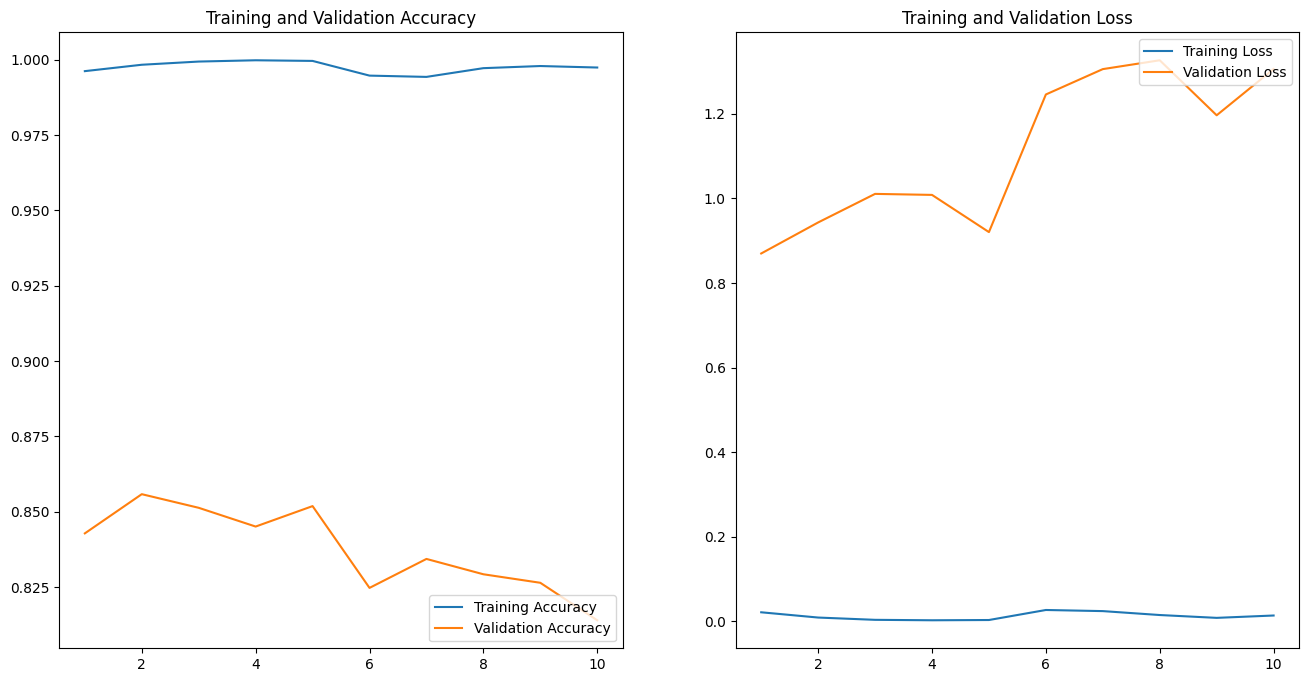

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

테스트 데이터에 대한 정확도는 80퍼를 넘겼다! 다만 더 상승하지는 않는다, 정규화도 적용해 보자

In [12]:
from tensorflow.keras.regularizers import l1_l2

model = tf.keras.Sequential([
    #Conv2D layer 설정 - 필터 32개, 커널 사이즈 3*3, 패딩 설정, 활성화 함수 relu, 첫 layer - 입력 이미지 크기 정의
    tf.keras.layers.Conv2D(
        16,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_regularizer=l1_l2(l1=0.001, l2=0.001), #l2 정규화 추가
        kernel_constraint=tf.keras.constraints.max_norm(3), #가중치 제한 
        input_shape=(img_height, img_width, 3),
    ),
    tf.keras.layers.Flatten(), #1차원 데이터로 변경
    tf.keras.layers.Dropout(0.5), #무작위 절반의 뉴런을 버림
    tf.keras.layers.Dense(classes, activation='softmax') #class의 종류 수 만큼 분류
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [13]:
num_epochs = 7
history = model.fit(train_1, epochs=num_epochs, validation_data=test)

Epoch 1/7
 61/222 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.2672 - loss: 48.9912

KeyboardInterrupt: 

In [17]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout

def my_model(input_shape,num_classes):
    inputs=Input(shape=input_shape)
    
    x=Conv2D(64,kernel_size=(7,7),strides=(7,7),padding='same' )(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    x=Conv2D(16,kernel_size=(3,3), strides=(2,2),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    x=Flatten()(x)
    x=Dropout(0.5)(x)
    x=Dense(num_classes,activation='softmax')(x)

    model=tf.keras.models.Model(inputs=inputs,outputs=x)
    return model

model=my_model([img_height, img_width, 3], classes)
optimizer=Adam()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
    
    

In [18]:
history = model.fit(train_2, epochs=50, validation_data=test)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.4654 - loss: 2.0768 - val_accuracy: 0.2397 - val_loss: 2.7183
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.7672 - loss: 0.8843 - val_accuracy: 0.4539 - val_loss: 1.8618
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.8111 - loss: 0.7003 - val_accuracy: 0.7908 - val_loss: 0.8388
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.8486 - loss: 0.5576 - val_accuracy: 0.7722 - val_loss: 0.8880
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8586 - loss: 0.5066 - val_accuracy: 0.7321 - val_loss: 1.0720
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.8739 - loss: 0.4282 - val_accuracy: 0.8575 - val_loss: 0.5696
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8899 - loss: 0.3864 - val_accuracy: 0.8496 - val_loss: 0.6340
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8960 - loss: 0.3512 - 

In [20]:
model.save("models/my_model.keras")

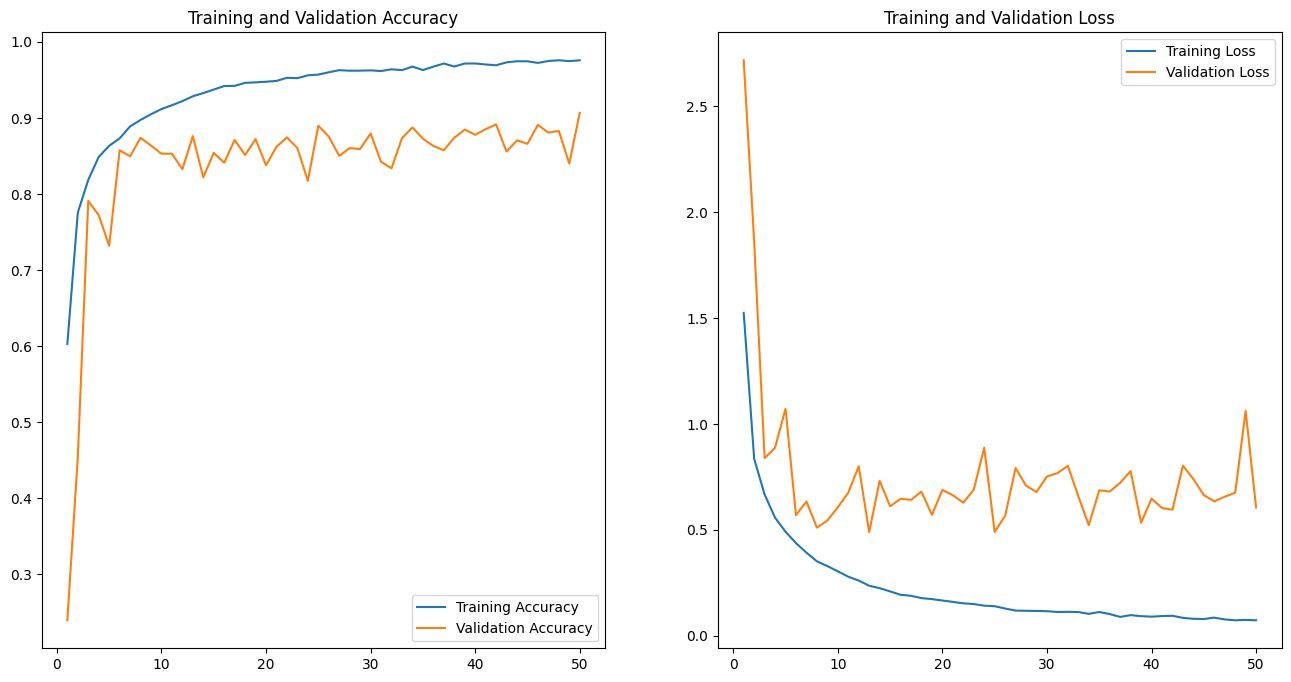

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 50 + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

최대 정확도 83퍼까지 올림 but 과적합 문제는 사라지지 않음 <결론> 데이터셋의 크기가 제일 큰 문제라고 생각됨 - 유명 모델들을 구현해보자

1: ResNet-18

In [43]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D

def resnet_block(inputs,kernel,filters,strides=1,activation='relu'):
    x=Conv2D(filters,kernel_size=(kernel,kernel),strides=strides, padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation(activation)(x)

    x=Conv2D(filters,kernel_size=(kernel,kernel),padding='same')(x)
    x=BatchNormalization()(x)

    if strides != 1 or inputs.shape[3] != filters: #input과 output의 크기가 달라지는 경우를 대비하는 코드
       inputs = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
       inputs = BatchNormalization()(inputs)

    x=Add()([inputs,x]) #input값과 output값을 더함으로서 input값의 소실을 막음 -> 기울기 소실 방지
    x=Activation(activation)(x)
    return x

def resnet_18(input_shape,num_classes):
    inputs=Input(shape=input_shape) #input 받는 layer
    x=Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same')(inputs) #필터 64 / 커널 사이즈 7*7 / 이동 간격 - 가로 2픽셀, 세로 2픽셀씩, 패딩 적용
    x=BatchNormalization()(x) #배치 정규화
    x=Activation('relu')(x) #활성화 함수 relu
    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x) #3*3 영역 최댓값 가져옴 / 이동 간격 - 가로 2픽셀, 세로 2픽셀씩, 패딩 적용
    x=resnet_block(x,3,64)
    x=resnet_block(x,3,64)

    x=resnet_block(x,3,128,strides=2)
    x=resnet_block(x,3,128)

    x=resnet_block(x,3,256,strides=2)
    x=resnet_block(x,3,256)

    x=resnet_block(x,3,512,strides=2)
    x=resnet_block(x,3,512)

    x=AveragePooling2D(pool_size=(5, 5), strides=(1, 1))(x)
    x=Flatten()(x)
    x=Dense(num_classes,activation='softmax')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    model=tf.keras.models.Model(inputs=inputs,outputs=x)
    return model

model_resnet=resnet_18([img_height, img_width, 3], classes)

model_resnet.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
num_epochs = 10
history = model_resnet.fit(train_1, epochs=num_epochs, validation_data=test)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 57s 749ms/step - accuracy: 0.2429 - loss: nan - val_accuracy: 0.1236 - val_loss: 12.1961
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 734ms/step - accuracy: 0.3437 - loss: nan - val_accuracy: 0.0541 - val_loss: 4.6729
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 731ms/step - accuracy: 0.3611 - loss: 8.7710 - val_accuracy: 0.0869 - val_loss: 18.0036
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 733ms/step - accuracy: 0.3676 - loss: 8.2107 - val_accuracy: 0.1486 - val_loss: 4.7560
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 732ms/step - accuracy: 0.3983 - loss: 8.2650 - val_accuracy: 0.3050 - val_loss: 4.8180
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 742ms/step - accuracy: 0.3957 - loss: nan - val_accuracy: 0.3514 - val_loss: 3.5214
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 733ms/step - accuracy: 0.4148 - loss: nan - val_accuracy: 0.5560 - val_loss: 2.0007
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 736ms/step - accuracy: 0.4446 - loss: 8.1636 - val_accuracy: 0.61

레이어가 깊어진다면? -> resnet-50 구현

In [62]:
from keras.applications import ResNet50
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

base_model = ResNet50(weights=None, include_top=False, input_shape=([img_height, img_width, 3]))

model_resnet50 = models.Sequential()
model_resnet50.add(base_model)
model_resnet50.add(layers.GlobalAveragePooling2D())
model_resnet50.add(layers.Dense(classes, activation='softmax'))

model_resnet50.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model_resnet50.fit(train_2, epochs=100, validation_data=test)

Epoch 1/100


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000022CCCBB0FB0>>
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

레이어가 깊어짐 -> 과적합이 매우 심해진 것을 볼 수 있음

소규모 데이터 셋에서도 좋은 성능을 보인다고 알려진 mobilenetv2 구현

In [139]:
from tensorflow.keras.applications import MobileNetV3Small

base_model = MobileNetV3Small(weights=None, include_top=False, input_shape=[224,224, 3])

model_mobile = models.Sequential()
model_mobile.add(base_model)
model_mobile.add(layers.GlobalAveragePooling2D())
model_mobile.add(layers.Dense(classes, activation='softmax'))

model_mobile.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [140]:
import random

def image_preprocessing(path, label):
    image = tf.io.read_file(path) #이미지 파일 로드
    image = tf.image.decode_jpeg(image, channels=3) #이미지 디코딩, 컬러(RGB)이미지기에 channels는 3으로 지정
    image = tf.image.resize(image, [224, 224])  # 이미지 크기 조정
    image = image / 255.0  # RGB값은 0~255의 값을 가짐 -> 255로 나누어 0~1의 값으로 정규화

    return image, label

def data_augmentation(image, label):
    image_modi = image
    i = random.randrange(1,10)
    if i == 7:
        image_modi = tf.image.random_flip_left_right(image_modi) #좌우 반전 - 좌우 반전되는 경우가 소수 -> 낮은 확률로 실행 
        #image_modi = tf.image.random_flip_up_down(image_modi) - 밈의 경우 상하 반전을 하는 경우는 거의 없음 -> 주석처리
    image_modi = tf.image.random_brightness(image_modi, max_delta=0.1) #밝기 조절
    image_modi = tf.image.random_contrast(image_modi, lower=0.9, upper=1.1) #대비 조절
    image_modi = tf.image.random_saturation(image_modi, lower=0.9, upper=1.1) #채도 조절
    image_modi = tf.image.random_hue(image_modi, max_delta=0.1) #색조 조절

    noise = tf.random.normal(shape=tf.shape(image_modi), mean=0.0, stddev=1.0, dtype=tf.float32)
    image_modi = tf.add(image_modi, noise) #노이즈 추가
    image_modi = tf.image.random_jpeg_quality(image_modi, min_jpeg_quality=70, max_jpeg_quality=100) #이미지 왜곡

    return image, label

def create_dataset(paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels)) #path, labels를 datasetV2로 만듦
    dataset = dataset.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE) #전처리

    augmented_datasets = []
    for _ in range(1):
        augmented_dataset = dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        augmented_datasets.append(augmented_dataset)

    # 원본 데이터셋과 증강된 데이터셋을 합침
    while augmented_datasets:
        dataset = tf.data.Dataset.concatenate(dataset, augmented_datasets.pop())

    dataset = dataset.shuffle(buffer_size=len(paths)) #기존 데이터셋은 레이블별로 모여 있음 -> 스까스까
    dataset = dataset.batch(batch_size) #한 번에 몇개 씩 입력될지 지정
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) #데이터 셋을 미리 로드해 병목현상 방지
    return dataset

batch_size = 32
train_3 = create_dataset(X_train, y_train, batch_size)

In [141]:

history = model_mobile.fit(train_3, epochs=100, validation_data=test)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 45s 256ms/step - accuracy: 0.5391 - loss: 1.4137 - val_accuracy: 0.0985 - val_loss: 2.4748
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 246ms/step - accuracy: 0.8309 - loss: 0.5280 - val_accuracy: 0.0985 - val_loss: 2.4744
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9011 - loss: 0.3114 - val_accuracy: 0.1274 - val_loss: 2.4868
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - accuracy: 0.9415 - loss: 0.1947 - val_accuracy: 0.0753 - val_loss: 2.4983
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.9601 - loss: 0.1277 - val_accuracy: 0.0985 - val_loss: 2.5096
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.9692 - loss: 0.1051 - val_accuracy: 0.0425 - val_loss: 2.5382
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.9646 - loss: 0.1147 - val_accuracy: 0.0753 - val_loss: 2.5839
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - accuracy: 0.9702 -

In [ ]:
import tensorflow as tf
import pandas as pd
import pickle
import os
from tensorflow.keras.preprocessing import image
import numpy as np

with open('models/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)
model = tf.keras.models.load_model('models/my_model.keras')

img_path = 'test/test.jpg'
img = image.load_img(img_path, target_size=(198, 177))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)

print(pred)
print(label_encoder.inverse_transform(np.argmax(pred, axis=1)))
